# Bagging

We consider bagging using the OOB error to automatically determine the number of basis models to use. Specifically, we keep adding one model trained on a bootstrap sample to the bagging ensemble at a time, and stop only when one of the following happens: (a) the number of models m in the ensemble reaches a pre-specified maximum number of models, or (b) m is at least 10, and $\bar{\epsilon}_{m}^{OOB}\geq \bar{\epsilon}_{m-5}^{OOB}$. Here the smoothed OOB error $\bar{\epsilon}_{m}^{OOB}$ is defined as $\bar{\epsilon}_{t}^{OOB}=\frac{1}{5}\sum _{i=1}^{5}{\epsilon}_{t-i+1}^{OOB}$, with ${\epsilon}_{i}^{OOB}$ being the OOB error for the ensemble consisting of the first $i$ models.

Note that we only consider bagging of probabilistic classifiers, and the prediction method we use here is: first use each individual classifier to predict the class distributions, then average over all the predicted distributions, and predict the most likely class. If an example is not an OOB example for any of the basis models, predict the first class. 


#### Choose 1 as random seed.

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, 
                                                    test_size = 0.3, random_state = 1)


We will introduce a dictionary variable called "self.oob_probs". The keys of self.obb_probs variable would be the indexes (from 0 to (the number of training samples - 1)) of training data.  
  
After fitted a basis model M($i$), we use this model M($i$) to predict the class distribution of each OOB samples OOB($i$), and then store the distribution dist($i$) in the dictionary by adding the new distribution dist($i$) into the old distribution sum(dist(1:$i$-1)).  
  
By doing so, we can store the class distributions of previous $i$ basis models but not the $i$ number of previous bootstrap samples. And the required memory would remain the same no matter how many basis models we have built.

In [2]:
from sklearn.base import clone
import numpy as np
from sklearn.utils import resample

class OOBaggingClassifier:
    def __init__(self, base_estimator, n_estimators=200):
        '''
        Parameters
        ----------
        base_estimator: a probabilistic classifier that implements the predict_proba function, such as DecisionTreeClassifier
        n_estimators: the maximum number of estimators allowed.
        '''
        self.base_estimator_ = base_estimator
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.oob_errors_ = []
        self.oob_probs = {}

    def fit(self, X, y, random_state = None):
        '''
        Parameters
        ----------
        X: an input array of shape (n_sample, n_features)
        y: an array of shape (n_sample,) containing the classes for the input examples
        random_state: random seed (for reproducible results)
        '''
        if random_state:
            np.random.seed(random_state)
        random_ints = np.random.randint(2*self.n_estimators, size = self.n_estimators)
        
        self.best_n = 0

        # initiate self.oob_probs dictionary
        if self.oob_probs == {}:
            for data_index in range(X.shape[0]):
                self.oob_probs[data_index] = []

        for i in range(self.n_estimators):
            estimator = clone(self.base_estimator_)

            # bootstrap sample
            X_sample, y_sample, selected = resample(X, y, list(range(X.shape[0])), 
                                                    n_samples = X.shape[0], random_state = random_ints[i])
            estimator.fit(X_sample, y_sample)
            # the indexes of OOB samples
            oob_indexes = [data_index for data_index in range(X.shape[0]) if data_index not in selected]
            for oob_index in oob_indexes:
                # make a prediction on the new OOB samples and add the probability into self.oob_probs
                oob_predicts_prob = estimator.predict_proba(X[oob_index].reshape(1, -1))
                if len(self.oob_probs[oob_index]):
                    self.oob_probs[oob_index] += oob_predicts_prob
                else:
                    self.oob_probs[oob_index] = oob_predicts_prob

            oob_incorrect = 0 # the number of incorrect predictions of OOB samples
            for oob_index, oob_prob in self.oob_probs.items():
                if len(oob_prob):
                    predicted_value = np.argmax(oob_prob, axis=1)
                else: 
                # if an example is not an OOB example for any of the basis models, predict the first class.
                    predicted_value = 0

                if predicted_value != y[oob_index]:
                    oob_incorrect += 1

            oob_error = oob_incorrect / X.shape[0]

            # save the OOB error and the new model
            self.estimators_.append(estimator)
            self.oob_errors_.append(oob_error)

            # stop early if smoothed OOB error increases (for the purpose of
            # this problem, we don't stop training when the criterion is
            # fulfilled, but simply set self.best_n to (i+1)).

            if (self.best_n == 0):
                if (i >= 9) and (self.oob_errors_[i-4:i] >= self.oob_errors_[i-9:i-5]):
                    self.best_n = (i + 1)

    def errors(self, X, y):
        '''
        Parameters
        ----------
        X: an input array of shape (n_sample, n_features)
        y: an array of shape (n_sample,) containing the classes for the input examples

        Returns
        ------
        error_rates: an array of shape (n_estimators,), with the error_rates[i]
        being the error rate of the ensemble consisting of the first (i+1)
        models.
        '''
        error_rates = []

        # compute all the required error rates
        for i in range(self.n_estimators):
            probs = None
            for j in range(i + 1):
                p = self.estimators_[j].predict_proba(X)
                if probs is None:
                    probs = p
                else:
                    probs += p
                    
            predicted_values = np.argmax(probs, axis=1)
            n_wrong_predicted = sum(predicted_values != y)
            error_rates.append(n_wrong_predicted / len(predicted_values))

        return error_rates

    def predict(self, X):
        '''
        Parameters
        ----------
        X: an input array of shape (n_sample, n_features)

        Returns
        ------
        y: an array of shape (n_samples,) containing the predicted classes
        '''
        probs = None
        for estimator in self.estimators_:
            p = estimator.predict_proba(X)
            if probs is None:
                probs = p
            else:
                probs += p
        return np.argmax(probs, axis=1)


#### The number of basis models chosen by the OOB error method is 30.

In [3]:
from sklearn.tree import DecisionTreeClassifier

# case 1
oob_clf1 = OOBaggingClassifier(DecisionTreeClassifier(), n_estimators = 200)
oob_clf1.fit(X_train, y_train, random_state = 1)
oob_error1 = oob_clf1.oob_errors_
test_error1 = oob_clf1.errors(X_test, y_test)
print("The number of basis models chosen by the OOB error method is", oob_clf1.best_n)

The number of basis models chosen by the OOB error method is 44


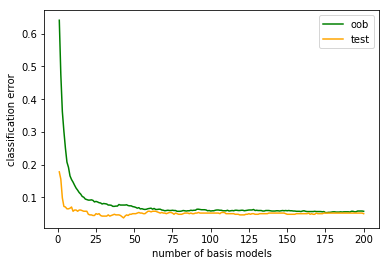

In [4]:
# Plot the OOB error and the test error against the number of models (from 1 to 200).

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(list(range(1, 201)), oob_error1, color = 'green', label = 'oob')
plt.plot(list(range(1, 201)), test_error1, color = 'orange', label = 'test')
plt.xlabel("number of basis models")
plt.ylabel("classification error")
plt.legend(loc = 1)
plt.show()

####  Use random seed 2 and 3.

In [5]:
# case 2: random seed = 2
oob_clf2 = OOBaggingClassifier(DecisionTreeClassifier(), n_estimators = 200)
oob_clf2.fit(X_train, y_train, random_state = 2)
oob_error2 = oob_clf2.oob_errors_
test_error2 = oob_clf2.errors(X_test, y_test)
print("The number of basis models chosen by the OOB error method is", oob_clf2.best_n)

The number of basis models chosen by the OOB error method is 37


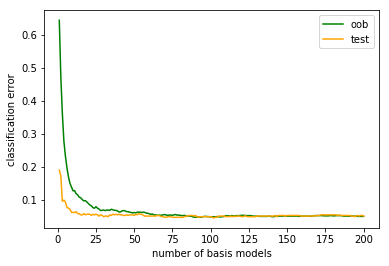

In [6]:
plt.plot(list(range(1, 201)), oob_error2, color = 'green', label = 'oob')
plt.plot(list(range(1, 201)), test_error2, color = 'orange', label = 'test')
plt.xlabel("number of basis models")
plt.ylabel("classification error")
plt.legend(loc = 1)
plt.show()

In [7]:
# case 3: random seed = 3
oob_clf3 = OOBaggingClassifier(DecisionTreeClassifier(), n_estimators = 200)
oob_clf3.fit(X_train, y_train, random_state = 3)
oob_error3 = oob_clf3.oob_errors_
test_error3 = oob_clf3.errors(X_test, y_test)
print("The number of basis models chosen by the OOB error method is", oob_clf3.best_n)

The number of basis models chosen by the OOB error method is 57


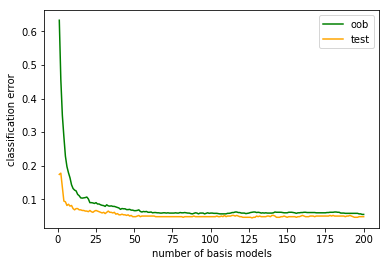

In [8]:
plt.plot(list(range(1, 201)), oob_error3, color = 'green', label = 'oob')
plt.plot(list(range(1, 201)), test_error3, color = 'orange', label = 'test')
plt.xlabel("number of basis models")
plt.ylabel("classification error")
plt.legend(loc = 1)
plt.show()

Comment:  
  
From the three plots above, the OOB errors are extremely large (between 0.2 and 0.7) when the numbers of basis models are small. But unsurprisingly, we can see that when the number of basis models is small, as the number of basis models increases, the OOB error and test error generally decrease rapidly, and the test error has stabilised when the OOB error stabilises (when the number of basis models is around 40). And we can achieve a low test error (less than 0.05) by using OOB error for selecting the number of models. So the OOB error is a good estimator for test performance.  
  
But also, we can see that from the three cases above, the number of basis models chosen by the OOB error method could vary. For example, the number of basis models we choose in case 2 is 37 while in case 3, we choose 57 basis models. So implement bagging for several times would be better than implement it only once or twice.